In [1]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import xgboost as xgb
import numpy as np

shap.initjs()

1. [Load Data](#Load-data)
2. [Train Model](#Train-model)
3. [SHAP evaluation](#SHAP-evaluation)

## Load data

In [2]:
caseType = 1
txtSubname = 'testP10N3'#'contiPositiveAge'
oldData = pd.read_csv('./data/oldData{}.csv'.format(txtSubname)).iloc[:, 1:]
youngData = pd.read_csv('./data/youngData{}.csv'.format(txtSubname)).iloc[:, 1:]
totalData = pd.read_csv('./data/totalData{}.csv'.format(txtSubname)).iloc[:, 1:]
coef = np.loadtxt('./data/coef.txt')
B_sex, B_trt, B_age, B_int = coef[0], coef[1], coef[2], coef[3]
print(B_sex, B_trt, B_age, B_int)
totalData

65.0 35.0 45.0 95.0


,T,Age,AgeTag,Sex,yo1,yo1CF,y1,y1CF,yo2,yo2CF,y2,y2CF,yo3,yo3CF,y3,y3CF
0,1.0,0.18,-1.0,1.0,225.0,-95.0,226.425027,-95.912755,130.6,60.6,130.209809,60.086101,130.6,15.6,128.177559,16.254648
1,-1.0,0.12,-1.0,1.0,-95.0,225.0,-91.944535,220.717015,50.4,120.4,50.963525,118.683386,20.4,120.4,18.556141,121.720797
2,-1.0,0.74,1.0,-1.0,25.0,-155.0,23.341845,-155.830984,-159.2,-89.2,-157.266194,-89.570332,-159.2,95.8,-154.951777,98.304993
3,-1.0,0.84,1.0,-1.0,25.0,-155.0,26.091929,-150.783989,-167.2,-97.2,-170.317561,-96.959969,-167.2,112.8,-166.479434,119.425698
4,1.0,0.48,-1.0,1.0,225.0,-95.0,225.260311,-91.182191,181.6,111.6,180.536011,112.218057,181.6,-8.4,182.667781,-9.392924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.0,0.76,1.0,-1.0,25.0,-155.0,26.805994,-153.577414,-160.8,-90.8,-165.236119,-91.581155,-160.8,99.2,-161.078938,100.251095
996,1.0,0.04,-1.0,-1.0,-155.0,25.0,-158.683663,23.509108,-33.2,-103.2,-36.701559,-94.816824,-23.2,-103.2,-27.800916,-102.910245
997,1.0,0.50,-1.0,1.0,225.0,-95.0,221.857374,-92.734226,185.0,115.0,184.672174,108.818185,185.0,-10.0,183.852132,-13.726831
998,1.0,0.12,-1.0,-1.0,-155.0,25.0,-155.445598,23.784363,-39.6,-109.6,-35.904318,-110.443007,-9.6,-109.6,-7.670100,-108.878674


In [3]:
X = totalData[["T", "Age", "Sex"]]
y = totalData["y"+str(caseType)]

## Train model

In [4]:
#Train model
model = xgb.XGBRegressor(objective="reg:squarederror",max_depth=10)
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## SHAP evaluation

In [5]:
explainer = shap.TreeExplainer(model)
shap_interaction = explainer.shap_interaction_values(X, tree_limit=-1)

In [6]:
#Get model predictions
y_pred = model.predict(X)

#Calculate mean prediction 
mean_pred = np.mean(y_pred)

#Sum of interaction values for first employee
sum_shap = np.sum(shap_interaction[0])

#Values below should be the same
print("Model prediction: {}".format(y_pred[0]))
print("Mean prediction + interaction values: {}".format(mean_pred+sum_shap))

Model prediction: 128.59652709960938
Mean prediction + interaction values: 128.5965576171875


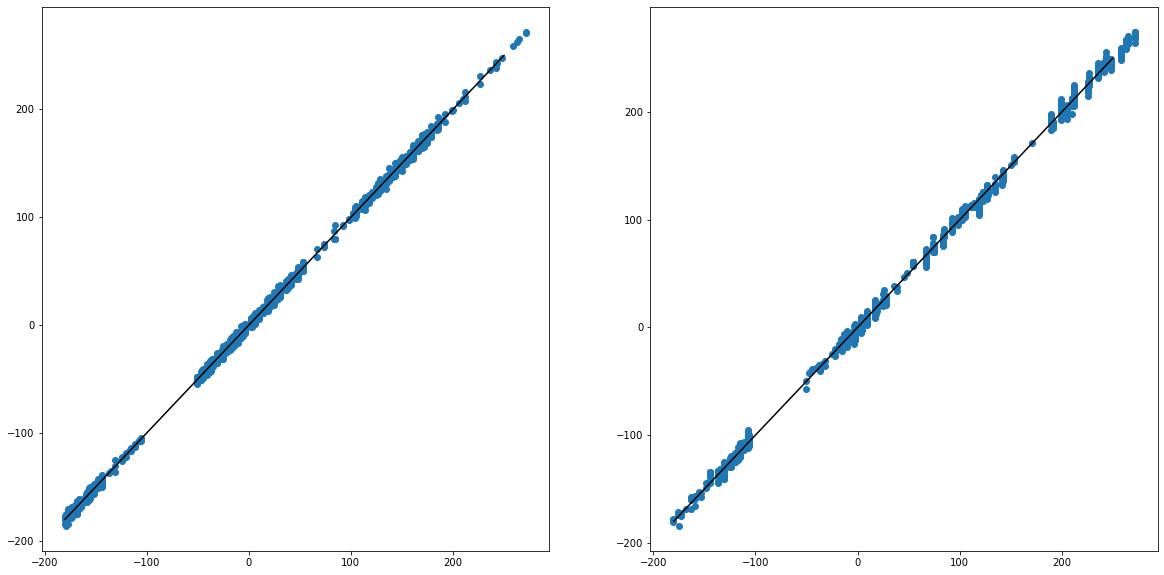

In [7]:
y_pred = model.predict(X)
cfX = X.copy()
cfX.iloc[:, 0] = - cfX.iloc[:, 0]
ycf_pred = model.predict(cfX)
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].scatter(y_pred, y)
axs[1].scatter(ycf_pred, totalData["y{}CF".format(caseType)])
axs[0].plot([-180, 250], [-180, 250], color='black')
axs[1].plot([-180, 250], [-180, 250], color='black')

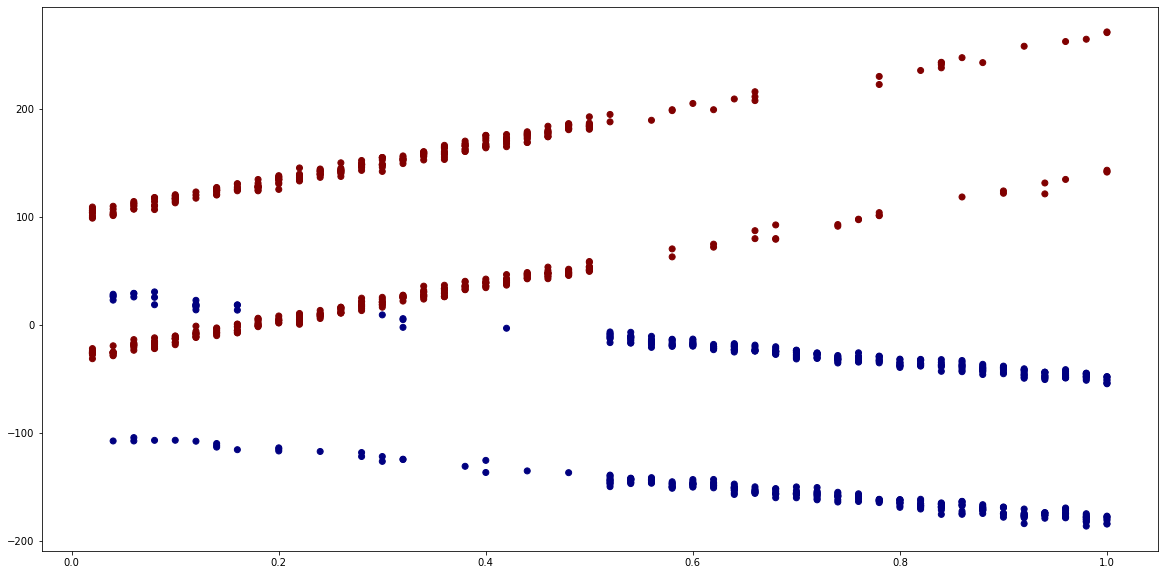

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
axs.scatter(totalData["Age"], y, c=totalData["T"], cmap="jet")

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'T'), Text(0, 1.5, 'Age'), Text(0, 2.5, 'Sex')])

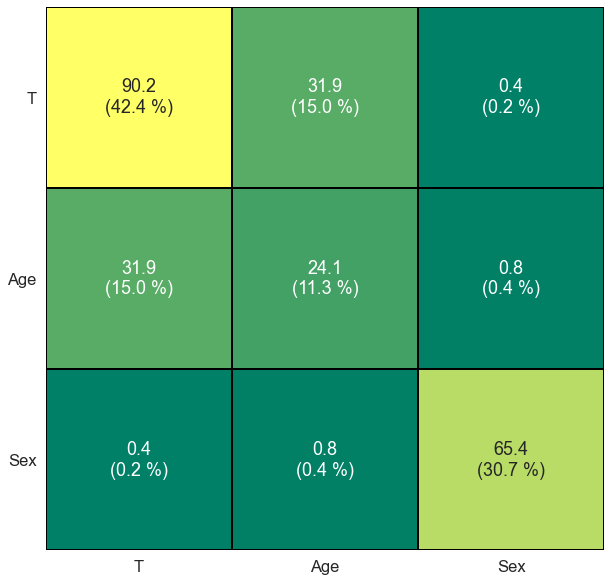

In [9]:
# Get absolute mean of matrices
mean_shap = np.abs(shap_interaction).mean(0)
df = pd.DataFrame(mean_shap,index=X.columns,columns=X.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2,inplace=True)
totalSum = 0
for i in range(mean_shap.shape[0]):
    for j in range(mean_shap.shape[1]):
        if i <= j:
            totalSum += mean_shap[i, j]

label = []
for i in range(mean_shap.shape[0]):
    for j in range(mean_shap.shape[1]):
        label.append("{:.1f}\n({:.1f} %)".format(mean_shap[i, j], mean_shap[i, j]/totalSum*100))
label = np.array(label).reshape(mean_shap.shape)
# display 
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(df,cmap='summer',annot=label, fmt="",cbar=False,linewidths=1, linecolor='black')
plt.yticks(rotation=0) 

## Evaluation

In [10]:
# Copy from https://github.com/AMLab-Amsterdam/CEVAE/evaluation.py
class Evaluator(object):
    def __init__(self, y, t, y_cf=None, mu0=None, mu1=None):
        self.y = y
        self.t = t
        self.y_cf = y_cf
        self.mu0 = mu0
        self.mu1 = mu1
        if mu0 is not None and mu1 is not None:
            self.true_ite = mu1 - mu0

    def rmse_ite(self, ypred1, ypred0):
        pred_ite = np.zeros_like(self.true_ite)
        idx1, idx0 = np.where(self.t == 1), np.where(self.t == -1)
        ite1, ite0 = self.y[idx1] - ypred0[idx1], ypred1[idx0] - self.y[idx0]
        pred_ite[idx1] = ite1
        pred_ite[idx0] = ite0
        return np.sqrt(np.mean(np.square(self.true_ite - pred_ite)))

    def abs_ate(self, ypred1, ypred0):
        return np.abs(np.mean(ypred1 - ypred0) - np.mean(self.true_ite))

    def pehe(self, ypred1, ypred0):
        return np.sqrt(np.mean(np.square((self.mu1 - self.mu0) - (ypred1 - ypred0))))

    def getPredITE(self, ypred1, ypred0):
        pred_ite = np.zeros_like(self.true_ite)
        idx1, idx0 = np.where(self.t == 1), np.where(self.t == -1)
        ite1, ite0 = self.y[idx1] - ypred0[idx1], ypred1[idx0] - self.y[idx0]
        pred_ite[idx1] = ite1
        pred_ite[idx0] = ite0
        return pred_ite

In [11]:
xt0 = X.copy()
xt0["T"] = -1
xt1 = X.copy()
xt1["T"] = 1
ypred0 = model.predict(xt0)
ypred1 = model.predict(xt1)

data = totalData
mu1, mu0 = np.zeros(ypred0.shape), np.zeros(ypred0.shape)
mu1[X["T"] == 1] = data["yo{}".format(caseType)][X["T"] == 1]
mu1[X["T"] == -1] = data["yo{}CF".format(caseType)][X["T"] == -1]
mu0[X["T"] == -1] = data["yo{}".format(caseType)][X["T"] == -1]
mu0[X["T"] == 1] = data["yo{}CF".format(caseType)][X["T"] == 1]

eva = Evaluator(y=np.array(data["y{}".format(caseType)]), 
                t=np.array(data["T"]), 
                y_cf=np.array(data["y{}CF".format(caseType)]), 
                mu0=mu0, 
                mu1=mu1)

print("Entire")
print("RMSE: {}".format(eva.rmse_ite(ypred1=ypred1, ypred0=ypred0)))
print("ATE : {}".format(eva.abs_ate(ypred1=ypred1, ypred0=ypred0)))
print("PEHE: {}".format(eva.pehe(ypred1=ypred1, ypred0=ypred0)))

Entire
RMSE: 4.143029292632063
ATE : 0.0978240966796875
PEHE: 3.1393621069043145


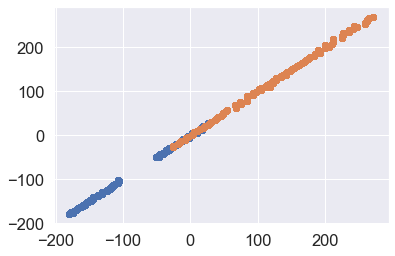

In [12]:
plt.scatter(ypred0, mu0)
plt.scatter(ypred1, mu1)

In [13]:
threshold = 0.50

In [14]:
dataSmall = data[data["Age"] <= threshold]
dataSmall

y = dataSmall["y"+str(caseType)]

Xsmall = dataSmall['T']
Xsmall = pd.concat((Xsmall, dataSmall.iloc[:, 1], dataSmall.iloc[:, 3]), axis=1)
arrXsmall = np.array(Xsmall)
ySmall = dataSmall['y{}'.format(caseType)]
yCFsmall = dataSmall['y{}CF'.format(caseType)]

modelSmall = xgb.XGBRegressor(objective="reg:squarederror",max_depth=10)
modelSmall.fit(arrXsmall, ySmall)
y_predSmall = modelSmall.predict(arrXsmall)
cfXsmall = Xsmall.copy()
cfXsmall.iloc[:, 0] = - cfXsmall.iloc[:, 0]
ycf_predSmall = modelSmall.predict(np.array(cfXsmall))

In [15]:
xt0 = Xsmall.copy()
xt0["T"] = -1
xt1 = Xsmall.copy()
xt1["T"] = 1
ypred0small = modelSmall.predict(np.array(xt0))
ypred1small = modelSmall.predict(np.array(xt1))


mu1small, mu0small = np.zeros(ypred0small.shape), np.zeros(ypred0small.shape)
mu1small[Xsmall["T"] == 1]  = dataSmall["yo{}".format(caseType)][Xsmall["T"] == 1]
mu1small[Xsmall["T"] == -1] = dataSmall["yo{}CF".format(caseType)][Xsmall["T"] == -1]
mu0small[Xsmall["T"] == -1] = dataSmall["yo{}".format(caseType)][Xsmall["T"] == -1]
mu0small[Xsmall["T"] == 1]  = dataSmall["yo{}CF".format(caseType)][Xsmall["T"] == 1]

evaSmall = Evaluator(y=np.array(dataSmall["y{}".format(caseType)]), 
                t=np.array(dataSmall["T"]), 
                y_cf=np.array(dataSmall["y{}CF".format(caseType)]), 
                mu0=mu0small, 
                mu1=mu1small)


print("Small")
print("RMSE: {}".format(evaSmall.rmse_ite(ypred1=ypred1small, ypred0=ypred0small)))
print("ATE : {}".format(evaSmall.abs_ate(ypred1=ypred1small, ypred0=ypred0small)))
print("PEHE: {}".format(evaSmall.pehe(ypred1=ypred1small, ypred0=ypred0small)))

Small
RMSE: 3.915145057389657
ATE : 0.51190185546875
PEHE: 2.6966973481827208


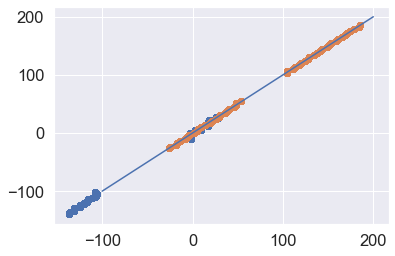

In [16]:
plt.scatter(ypred0small, mu0small)
plt.scatter(ypred1small, mu1small)
plt.plot([-100, 200], [-100, 200])

In [17]:
dataLarge = data[data["Age"] > threshold]
dataLarge

y = dataLarge["y"+str(caseType)]

Xlarge = dataLarge['T']
Xlarge = pd.concat((Xlarge, dataLarge.iloc[:, 1], dataLarge.iloc[:, 3]), axis=1)
arrXlarge = np.array(Xlarge)
yLarge = dataLarge['y{}'.format(caseType)]
yCFlarge = dataLarge['y{}CF'.format(caseType)]

modelLarge = xgb.XGBRegressor(objective="reg:squarederror",max_depth=10)
modelLarge.fit(arrXlarge, yLarge)
y_predLarge = modelLarge.predict(arrXlarge)
cfXlarge = Xlarge.copy()
cfXlarge.iloc[:, 0] = - cfXlarge.iloc[:, 0]
ycf_predLarge = modelLarge.predict(np.array(cfXlarge))

In [18]:
xt0 = Xlarge.copy()
xt0["T"] = -1
xt1 = Xlarge.copy()
xt1["T"] = 1
ypred0large = modelLarge.predict(np.array(xt0))
ypred1large = modelLarge.predict(np.array(xt1))


mu1large, mu0large = np.zeros(ypred0large.shape), np.zeros(ypred0large.shape)
mu1large[Xlarge["T"] == 1] = dataLarge["yo{}".format(caseType)][Xlarge["T"] == 1]
mu1large[Xlarge["T"] == -1] = dataLarge["yo{}CF".format(caseType)][Xlarge["T"] == -1]
mu0large[Xlarge["T"] == -1] = dataLarge["yo{}".format(caseType)][Xlarge["T"] == -1]
mu0large[Xlarge["T"] == 1] = dataLarge["yo{}CF".format(caseType)][Xlarge["T"] == 1]

evaLarge = Evaluator(y=np.array(dataLarge["y{}".format(caseType)]), 
                t=np.array(dataLarge["T"]), 
                y_cf=np.array(dataLarge["y{}CF".format(caseType)]), 
                mu0=mu0large, 
                mu1=mu1large)

print("Large")
print("RMSE: {}".format(evaLarge.rmse_ite(ypred1=ypred1large, ypred0=ypred0large)))
print("ATE : {}".format(evaLarge.abs_ate(ypred1=ypred1large, ypred0=ypred0large)))
print("PEHE: {}".format(evaLarge.pehe(ypred1=ypred1large, ypred0=ypred0large)))

Large
RMSE: 4.689069865730711
ATE : 0.393035888671875
PEHE: 3.9274454199945206


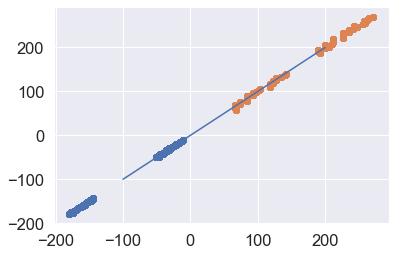

In [19]:
plt.scatter(ypred0large, mu0large)
plt.scatter(ypred1large, mu1large)
plt.plot([-100, 200], [-100, 200])